In [3]:
import h5py
import numpy as np
import pandas as pd 
import os
import numpy as np
import re
import csv
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import re

In [4]:
def convert_csv_to_txt(input_file,output_file):
   
    with open(input_file, 'r') as csv_file, open(output_file, 'w') as space_delimited_file:
        csv_reader = csv.reader(csv_file)
        for row in csv_reader:
            space_delimited_file.write(' '.join(row) + '\n')

    print(f'CSV file "{input_file}" converted to space-delimited file "{output_file}"')


In [5]:
def read_file(file):
    hf = h5py.File(file, 'r')
    attributes = []
    for key in hf.keys():
        attributes.append(key)
    
    return attributes, hf

In [7]:
def get_data(hf,attributes):
    data = []
    pm = []
    acc_pm = []
    loss_pm = []
    loss_gm = []
    for i in range(len(attributes)):
        ai = hf.get(attributes[i])
        ai = np.array(ai)
        data.append(ai)
    
    return data


In [177]:
def plot_convergence(df_loss, df_accuracy, fig_path):
    head_value = 1000
    mag_head = 100
    df_loss = df_loss.head(head_value)
    df_accuracy = df_accuracy.head(head_value)
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Adjusted for better display
    
    # Define a list of colors for the plots
    colors = ['green', 'magenta', 'black', 'red']
    
    handles, labels = [], []
    dfs = [(df_loss, 'log'), (df_accuracy, 'linear')]
    manual_location_loss = (-0.02, 0.0, 1.0, 1.0)
    manual_location_acc = (-0.015, 0.1, 1.0, 1.0)
    for ax_index, (df, scale_type) in enumerate(dfs):
        ax = axs[ax_index]
        for col, color in zip(sorted(df.columns), colors):  # Sorting columns and using colors
            line, = ax.plot(df.index, df[col], label=col, color=color)  # Set color manually
            handles.append(line)
            labels.append(col)

        ax.set_xticks(range(0, head_value+1, int(head_value/5))) # Setting x-axis ticks
        ax.tick_params(axis='x', labelsize=16)  
        ax.tick_params(axis='y', labelsize=16)
        ax.grid(True)
        ax.set_yscale(scale_type)  # Set y-axis scale

        # Add inset for the df_loss plot
        if ax_index == 0:  # Assuming df_loss is the first plot
            axins = inset_axes(ax, width="50%", height="50%",bbox_to_anchor=manual_location_loss, loc='upper right', bbox_transform=ax.transAxes)
            df = df.head(mag_head)
            for col, color in zip(sorted(df.columns), colors):
                axins.plot(df.index, df[col], color=color)
                axins.set_yscale('log')
            # Customize the inset plot (e.g., set ticks) based on your data range
            axins.set_xticks(range(0, mag_head+1, int(mag_head/5)))
            axins.set_yticks([])
            axins.tick_params(axis='x', labelsize=14)  
            axins.tick_params(axis='y', labelsize=14)
    
        # Add inset for the df_loss plot
        if ax_index == 1:  # Assuming df_loss is the first plot
            axins = inset_axes(ax, width="40%", height="40%",bbox_to_anchor=manual_location_acc, loc='lower right', bbox_transform=ax.transAxes)
            df = df.head(mag_head)
            for col, color in zip(sorted(df.columns), colors):
                axins.plot(df.index, df[col], color=color)
                axins.set_yscale('log')
            # Customize the inset plot (e.g., set ticks) based on your data range
            axins.set_xticks(range(0, mag_head+1, int(mag_head/5)))
            axins.set_yticks([])
            axins.tick_params(axis='x', labelsize=14)  
            axins.tick_params(axis='y', labelsize=14)

    unique_handles, unique_labels = [], []
    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            unique_handles.append(handle)
            unique_labels.append(label)

    indexes = ['Validation Loss', 'Validation Accuracy']
    
    fontsize = 20
    for i, ax in enumerate(axs):
        ax.set_ylabel(indexes[i], fontsize=fontsize)
        ax.set_xlabel('Global Iteration', fontsize=fontsize)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fig.subplots_adjust(top=0.85)
    legend_fontsize = 20  # Specify font size
    fig.legend(unique_handles, unique_labels, loc='upper center', ncol=4, title="", fontsize=legend_fontsize, title_fontsize=legend_fontsize)
    
    plt.draw()
    plt.savefig(fig_path + 'client_part_l1_100.png', bbox_inches='tight', dpi=300)

    plt.show()

In [141]:
# Function to extract the numerical value from the column names
def extract_value(col_name):
    match = re.search(r"p = ([\d\.]+)", col_name)
    if match:
        return float(match.group(1))
    else:
        return 0

In [185]:
def convergence_analysis(path, fig_path):
    df_loss = pd.DataFrame()
    df_accuracy = pd.DataFrame()
    df_gap = pd.DataFrame()

    dir_list = os.listdir(path)
    #print(dir_list)
    for file_name in dir_list:
    
        if file_name.endswith(".h5"):
            # Regular expression pattern to match 'client_frac_' followed by any number
            print(file_name)
            
                # Regular expression to find 'client_frac_*'
            pattern = r'client_frac_(0\.\d+|1\.0)'

            if file_name == "lmo_l1_lambda_0_0.01_client_frac_0.1_labels_3_global_iters_1000_21_03_2024.h5":
                column_name = "p = 0.1"
            elif file_name == "lmo_l1_lambda_0_0.01_client_frac_0.2_labels_3_global_iters_1000_21_03_2024.h5":
                column_name = "p = 0.2"
            elif file_name == "lmo_l1_lambda_0_0.01_client_frac_0.5_labels_3_global_iters_1000_21_03_2024.h5":
                column_name = "p = 0.5"
            elif file_name == "lmo_l1_lambda_0_0.01_client_frac_1.0_labels_3_global_iters_1000_21_03_2024.h5":
                column_name = "p = 1.0"
            # if eta_0_value in column_name:
                # print(f"column name : {column_name}")
            attributes, hf = read_file(path+file_name)

            data = get_data(hf,attributes)
            #id=0
            for key in hf.keys():
                attributes.append(key)
            # print("id [",id,"] :", key)
            #id+=1
                
            val_loss = np.array(hf.get('global_test_loss'))
            #print(f"val_loss : {val_loss}")
            val_acc = np.array(hf.get('global_test_accuracy'))
            #print(val_acc)
            #print(f"val_acc : {val_acc}")
            # gap = np.array(hf.get('fw_gap'))
                
            df_loss[column_name] = val_loss
            df_accuracy[column_name] = val_acc
            
            # Sort the DataFrame columns based on the extracted numerical value
            sorted_columns_loss = sorted(df_loss.columns, key=extract_value)
            sorted_columns_acc = sorted(df_accuracy.columns, key=extract_value)
            # Reorder the DataFrame according to the sorted columns
            df_loss_1 = df_loss[sorted_columns_loss]
            df_acc_1 = df_accuracy[sorted_columns_acc]
            # print(df_loss)
            # print(df_accuracy)       
    plot_convergence(df_loss_1, df_acc_1, fig_path)

lmo_l1_lambda_0_0.01_client_frac_0.2_labels_3_global_iters_1000_21_03_2024.h5
lmo_l1_lambda_0_0.01_client_frac_1.0_labels_3_global_iters_1000_21_03_2024.h5
lmo_l1_lambda_0_0.01_client_frac_0.1_labels_3_global_iters_1000_21_03_2024.h5
lmo_l1_lambda_0_0.01_client_frac_0.5_labels_3_global_iters_1000_21_03_2024.h5


/tmp/ipykernel_825679/1341490802.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


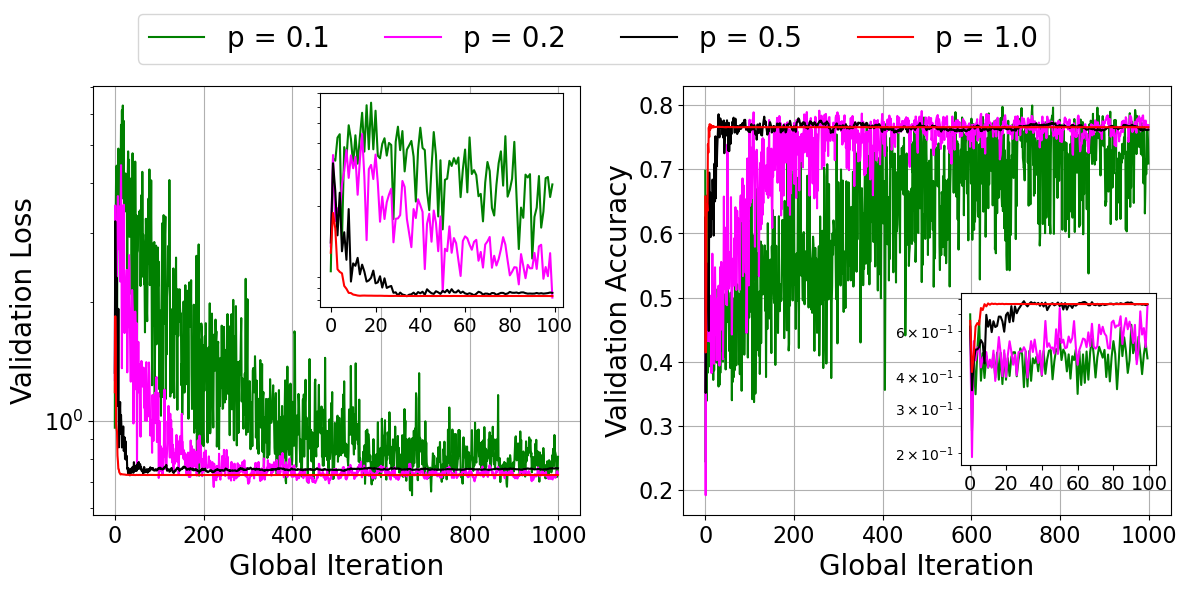

In [186]:
path = "/proj/sourasb-220503/codebase/FedFWplus/results/FedFW/SYNTHETIC/MCLR/ablation_new/client_part/lmo_l1/3/lambda_0.01/"
fig_path = '/proj/sourasb-220503/codebase/FedFWplus/results/FedFW/SYNTHETIC/MCLR/ablation_new/client_part/lmo_l1/3/lambda_0.01/'
convergence_analysis(path, fig_path)